# Labeling: Matrix Flags


## Abstract 

The matrix flag labeling method is a multistep labeling method meant to match a data window of price data for a single stock with a template. In the literature, the template presented is a bull flag 10 by 10 template, with the first 7 columns representing the consolidation following an initial price surge, and the final 3 represent the breakout. Each column of the template corresponds to a chronological tenth of the data, and each row corresponds to a decile relative to the entire data window. Each element contains the proportion of points in each tenth that corresponds to the appropriate decile given by row. Once the data has been transformed this way, it is multiplied element-wise with the template, and the sum of all elements in the resulting matrix is the scalar value denoting total fit for the day. The higher the fit, the better match with the template pattern.

## Introduction 

Labeling price data according to a template to identify patterns in price changes is featured in the following paper:
["Stock market trading rule based on pattern recognition and technical analysis: Forecasting the DJIA index with intraday data."](https://www.sciencedirect.com/science/article/abs/pii/S0957417415002110), by Cervelló-Royo et al., 2015.

This method was originally introduced in [Stock market trading rule discovery
using technical charting heuristics.](http://chart-patterns.technicalanalysis.org.uk/LMPR02.pdf), by Leigh et al., 2002, which describes this method in more detail.

A bull flag occurs when a stock's price rapidly increases, followed by a downwards trending consolidation period, followed by a breakout increase in price legitimizing and confirming the original increase. As defined, "A bull flag pattern is a horizontal or downward sloping flag of consolidation followed by a sharp rise in the positive direction, the breakout." [Leigh et al. 2002]. Being able to identify the early stages of the breakout process can lead to a profitable strategy of buying the breakout and then selling some number of days later, when the price has theoretically stabilized again.

Cervelló-Royo et al. expand on Leigh et al.'s work by proposing a new bull flag pattern which ameliorates some weaknesses in Leigh's original template, such as the possibility of false positives given the path the stock took. Additionally, he applies this bull flag labeling method to intraday candlestick data, rather than just daily closing prices.

## How it works

The bull flag labeling pattern requires the use of a template to match the price data to. Below is an example bull flag
template originally used by Leigh et al. in 2002, and mentioned by Cervelló-Royo et al.

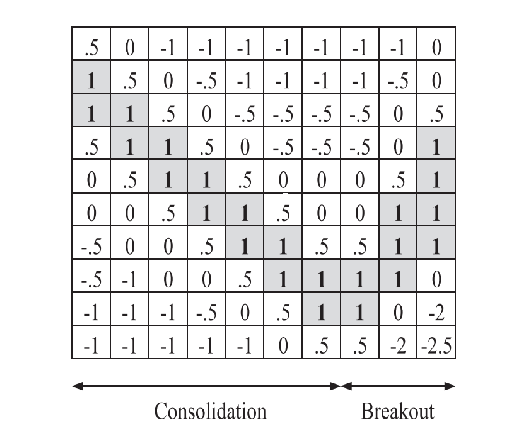

In [1]:
from IPython.display import Image
Image(filename='images/bull_flag_template.png')

_*Fig. 1:*_ Original bull flag template. First 7 columns represend the consolidation while the last 3 represent breakout.

The matrix flag labeling method, in order to find a single day's fit, consists of the following steps:

 - The data window is taken, which consists of the current day's price and a number of days preceding.
 - The prices in the data window are ranked and decile cutoffs are found. A mapping is found between each price and its decile.
 - The data window is split into 10 chronological buckets each containing a tenth of the data window.
 - Each data window bucket is converted to a column of 10 elements, with the first bucket corresponding to the leftmost column, the second
   to the second from left, and so on until the last bucket corresponds to the rightmost column. Each row in a column corresponds to decile over
   the entire data window, with the top row corresponding to top 90-100th percentile, second row corresponding to the 80-90th percentile, and
   so on.
 - The mapping between price and decile over the data window is applied, and each row consists of the proportion of points in the bucket which
   falls into each decile. For example, suppose the second bucket contains 50% points in the 20-30th percentile, and 50% points in the 0-10th
   percentile. The corresponding column would be, from top to bottom, \[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5\]. This process is done for all ten
   buckets, until a 10 by 10 matrix is formed.
 - This 10 by 10 matrix is multiplied element-wise by the template. The sum of all elements of this resulting matrix is calculated to be the
   total fit for the day.
 - If a threshold is given, the fit is converted to a categorical label, with the positive class given if the fit equals or exceeds the
   threshold, and the negative class otherwise. The value of the threshold depends on how strict of a classifier the user
   desires, and the allowable values based on the template matrix.

It's perhaps easiest to illustrate this process with a simple example. Suppose we have the following data window of 20
prices \[100, 102, ..., 118, 120, 118, ..., 104, 102\] i.e. rising monotonically to 120 and then falling back to 102.
The decile cutoffs are then \[102, 104, ..., 120\]. Note that these cutoffs are right inclusive, so a value of 102 would
fit into the (100, 102) percentile.

We split the data into ten chronological subsets such that the first subset is \[100, 102\]. 100% of elements in the first subset fall into the lowest decile, so the corresponding column would be \[0, 0, 0, 0, 0, 0, 0, 0, 0, 1\]. The second subset is \[104, 106\], of which 1 out of 2 prices is in the 2nd decile, and the other is in the 3rd decile, so the column would be \[0, 0, 0, 0, 0, 0, 0, 0.5, 0.5, 0\]. This is done until the entire 10 by 10 matrix is generated. The columns in this matrix represent the 10 chronological subsets, and each element in the column represents the proportion of points in each subset corresponding to its respective decile over the entire data window.

This matrix is then multiplied element-wise by the template, and resulting values are summed to get the total template fit. The higher the fit, the better match to the template. Using the template shown above, the highest possible fit is 10.

---
## Examples of use

In [2]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import yfinance as yf

# Import MlFinLab tools
from mlfinlab.labeling.matrix_flags import MatrixFlagLabels

register_matplotlib_converters() 

In [3]:
# Load price data. This method works on price data for a single stock, so a pd.Series must be used
msft = yf.Ticker('SPY')
msft_df = msft.history(start='2019-1-1', end ='2020-5-18')

close = msft_df['Close']
close.head()

Visualizing the data.

In [4]:
fig, ax = plt.subplots()
ax = plt.plot(close)
fig.autofmt_xdate()
plt.title('MSFT Stock Price')
plt.xlabel('Date');

## Getting scores

In [5]:
# We will use a window of 40
window1 = 40
Flags = MatrixFlagLabels(prices=close, window=window1, template_name='leigh_bull')
Flags.apply_labeling_matrix()

The higher the fit value for the day, the better the prices in the window preceding match the bull flag template. For categorical labels, we can use a threshold. Daily fits above the threshold will return a positive label.

In [6]:
# Use threshold of 3
categorical = Flags.apply_labeling_matrix(threshold=3)
categorical.value_counts()

## Impact of window size

We can visualize the points which get identified as being part of a bull flag pattern. The positive class marked on the figure match visually what a bull flag can look like. However, it's important to use the appropriate window relative to the timescale of price movements in the underlying; using too large or small of a window may result in missed labels.

In [7]:
positives = close[window1:][categorical==1]

fig, ax = plt.subplots()
ax = plt.plot(close)
plt.scatter(positives.index, positives, color='g')
fig.autofmt_xdate()
plt.title('Window = 40 days');

Here are similar visualizations for varying window sizes.

In [8]:
# Window is 10
Flags2 = MatrixFlagLabels(prices=close, window=10, template_name='leigh_bull')
categorical2 = Flags2.apply_labeling_matrix(threshold=3)
positives2 = close[10:][categorical2==1]
fig, ax = plt.subplots()
ax = plt.plot(close)
plt.scatter(positives2.index, positives2, color='g')
fig.autofmt_xdate()
plt.title('Window = 10 days');

In [9]:
# Window is 80
Flags3 = MatrixFlagLabels(prices=close, window=80, template_name='leigh_bull')
categorical3 = Flags3.apply_labeling_matrix(threshold=3)
positives3 = close[80:][categorical3==1]
fig, ax = plt.subplots()
ax = plt.plot(close)
plt.scatter(positives3.index, positives3, color='g')
fig.autofmt_xdate()
plt.title('Window = 80 days');

As we can see, having a shorter window results in identifying short term, more granular bull flags, while missing longer term trends. Having a longer window identifies longer term bull trends, but misses shorter term prices movements.

## Setting custom template

The default template is the one used by Leigh et al. However, there are some weaknesses with that template, in that false positives are possible depending on the path of prices \[Cervello-Royo et al., 2015\]. Referring to the template above, it is possible to trace the +1 values through the first 8 columns, and then rather than breaking out, trace the 0, and -2 values in the final 2 columns. This results in a very high fit value of 6, which should indicate a strong bull flag, but this is clearly a false positive. Cervelló-Royo et al. propose another template, which would ameliorate this problem. This template is likely only appropriate for intraday data, such as 15 minute bars, as it is too strict, with only 1 positive cell, to be used on end-of-day prices, which would demonstrate more local randomness.

In [10]:
# Cervelló-Royo's template
new_template = pd.DataFrame([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, -1, -1, -1, -1, -1, -1],
                            [0, 0, 0, -1, -2, -2, -2, -2, -2, -2],
                            [0, 0, -1, -3, -3, -3, -3, -3, -3, -3],
                            [0, -1, -3, -5, -5, -5, -5, -5, -5, -5],
                            [0, -1, -5, -5, -5, -5, -5, -5, -5, -5],
                            [0, -1, -5, -5, -5, -5, -5, -5, -5, -5],
                            [5, -1, -5, -5, -5, -5, -5, -5, -5, -5]])

In [11]:
Flags4 = MatrixFlagLabels(prices=close, window=30, template_name=None)
Flags4.set_template(new_template)
Flags4.template

## Bear instead of bull flags

Let's stick to the original template, but flip it horizontally to create the bear flag template instead. Note that we could have also initialized with template_name='leigh_bear' instead also.

In [12]:
window5=40
Flags5 = MatrixFlagLabels(prices=close, window=window5, template_name='leigh_bull')
bear_template = pd.DataFrame(np.flip(np.array(Flags5.template), axis=0))
Flags5.set_template(bear_template)
Flags5.template

In [13]:
categorical5 = Flags5.apply_labeling_matrix(threshold=3)
positives5 = close[window5:][categorical5==1]
fig, ax = plt.subplots()
ax = plt.plot(close)
plt.scatter(positives5.index, positives5, color='g')
fig.autofmt_xdate()
plt.title('Window = 40 days, Bear flags');

## Error Handling

When initializing the class, note that the length of data series must be at least 10, window must be at least 10, length of data cannot be less than the window, and the data must be a pd.Series.

In [14]:
try:
    MatrixFlagLabels(close[0:7], window=30)
except Exception as exc:
    print(exc)

try:
    MatrixFlagLabels(close[0:50], window=5)
except Exception as exc:
    print(exc)
    
try:
    MatrixFlagLabels(close[0:30], window=100)
except Exception as exc:
    print(exc)

try:
    MatrixFlagLabels([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], window=10)
except Exception as exc:
    print(exc)   

When setting a new template, the template must be a 10 by 10 matrix without any NaN values.

In [15]:
wrong_shape = pd.DataFrame(np.random.randint(-3, 3, size=(9, 10)))
right_shape_with_nan = pd.DataFrame(np.random.randint(-3, 3, size=(10, 10)))
right_shape_with_nan.iloc[2,2] = np.nan

In [16]:
flags_error = MatrixFlagLabels(close[0:50], 10)
                              
try:
    flags_error.set_template(wrong_shape)
except Exception as exc:
    print(exc)

try:
    flags_error.set_template(right_shape_with_nan)
except Exception as exc:
    print(exc)

---
## Conclusion

This notebook demonstrates the method of applying a template matrix to data for labeling, which works on price data, where the label for a given day depends on price for the day and the preceding window number of prices. The data in this data window are split into 10 equally sized chronological buckets, and the values are mapped to their deciles over the data window. Each column from left to right corresponds to a chronological data bucket, and each row corresponds to a decile over the entire window, with the top row representing the highest decile, the next row the second highest and so on. The elements are populated by the proportion of data points in each bucket which fall in the decile determined by row. This transformed matrix is then multiplied element-wise with the template, and the sum of all elements in the resulting matrix is summed to find the total fit.

This method depends on the user knowing the correct template to use, as well as understanding the time scale of the data when setting a window. Windows which are small will catch granular changes, but not longer term trends, while large windows will capture long term trends but not small changes.

## References

1. Cervelló-Royo, R., Guijarro, F. and Michniuk, K., 2015. Stock market trading rule based on pattern recognition and technical analysis: Forecasting the DJIA index with intraday data. Expert Systems with Applications, 42(14), pp.5963-5975.
2. Leigh, W., Modani, N., Purvis, R. and Roberts, T., 2002. Stock market trading rule discovery using technical charting heuristics. Expert Systems with Applications, 23(2), pp.155-159.